<a href="https://colab.research.google.com/github/kiran-bhandari16/LSTM-Stock-Price-Prediciton/blob/main/Economic_Political_NewsSentiment_Analysis_with_Polarity_and_Subjectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings
warnings.filterwarnings('ignore')


from textblob import TextBlob

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving economical.csv to economical.csv
Saving political.csv to political.csv
Saving sbl_price.csv to sbl_price.csv


In [ ]:
economic_df=pd.read_csv("economical.csv")
economic_df.head()

,Date,economictext
0,2016-04-25,['PAC directs NEA to stop work of Lower Solu u...
1,2016-05-4,['Kate Upton announces engagement to Justin Ve...
2,2016-06-5,"['Govt, CAAN seal deal on construction of int’..."
3,2016-06-10,['CIAA hurdle could prove costly: NT official'...
4,2016-06-11,['Pokhara is cheapest tourism destination: For...


In [ ]:
economic_df.shape

(2143, 2)

In [ ]:
economic_df.set_index("Date", inplace=True)
economic_df

,economictext
Date,
2016-04-25,['PAC directs NEA to stop work of Lower Solu u...
2016-05-4,['Kate Upton announces engagement to Justin Ve...
2016-06-5,"['Govt, CAAN seal deal on construction of int’..."
2016-06-10,['CIAA hurdle could prove costly: NT official'...
2016-06-11,['Pokhara is cheapest tourism destination: For...
...,...
2022-06-25,['Pokhara Metropolitan City brings new budget ...
2022-06-26,['17 cooperatives put in blacklist on charge o...
2022-06-27,['Nepal received FDI commitments of Rs 51.56 b...


In [ ]:
political_df=pd.read_csv("political.csv")
political_df.head()

,Date,politicaltext
0,2016-04-25,"['NHRC: Govt quake response too slow, NGOs non..."
1,2016-06-5,['Govt distributed budget on its own will: Deu...
2,2016-06-6,"['7 appellate courts to become high courts', '..."
3,2016-06-7,['PM Oli calls for national unity govt']
4,2016-06-9,"[""Neupane elected RPP Nepal's Makawanpur Chair""]"


In [ ]:
political_df.shape

(2170, 2)

In [ ]:
political_df.set_index("Date", inplace=True)
political_df

,politicaltext
Date,
2016-04-25,"['NHRC: Govt quake response too slow, NGOs non..."
2016-06-5,['Govt distributed budget on its own will: Deu...
2016-06-6,"['7 appellate courts to become high courts', '..."
2016-06-7,['PM Oli calls for national unity govt']
2016-06-9,"[""Neupane elected RPP Nepal's Makawanpur Chair""]"
...,...
2022-06-25,"[""Khadka appointed chief of NC's central polic..."
2022-06-26,"['National Assembly meeting being held today',..."
2022-06-27,['Newly-appointed ministers to be sworn in tod...


In [ ]:
stock_df=pd.read_csv("sbl_price.csv")
stock_df.head()

,S.N.,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,1,2022-06-29,318.90,318.90,310.00,315.00,0.64,"19,455.00","6,127,716.20"
1,2,2022-06-28,312.00,316.50,306.00,313.00,0.32,"18,396.00","5,707,986.70"
2,3,2022-06-27,322.00,325.00,310.00,312.00,-2.50,"35,290.00","11,125,995.50"
3,4,2022-06-26,312.90,320.00,308.00,320.00,4.23,"90,805.00","28,577,745.10"
4,5,2022-06-24,305.00,310.00,298.20,307.00,-0.97,"83,733.00","25,399,389.80"


In [ ]:
stock_df.shape

(2000, 9)

In [ ]:
stock_df=stock_df[['Date','Open','High','Low','Ltp','Qty','Turnover']]
stock_df

,Date,Open,High,Low,Ltp,Qty,Turnover
0,2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20"
1,2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70"
2,2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50"
3,2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10"
4,2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80"
...,...,...,...,...,...,...,...
1995,2013-03-21,306.00,311.00,303.00,308.00,"2,682.00","821,123.00"
1996,2013-03-20,312.00,312.00,306.00,306.00,849.00,"261,298.00"
1997,2013-03-19,311.00,312.00,309.00,312.00,"2,140.00","663,393.00"
1998,2013-03-18,315.00,317.00,305.00,311.00,"2,910.00","897,326.00"


In [ ]:
start_date='2016-06-10' 
end_date='2022-06-29'

# Select DataFrame rows between two dates
mask = (stock_df['Date'] >= start_date ) & (stock_df['Date'] <=  end_date)
stock_df = stock_df.loc[mask]

In [ ]:
stock_df

,Date,Open,High,Low,Ltp,Qty,Turnover
0,2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20"
1,2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70"
2,2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50"
3,2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10"
4,2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80"
...,...,...,...,...,...,...,...
1359,2016-07-17,869.00,955.00,886.00,955.00,"2,660.00","2,538,590.00"
1360,2016-07-14,790.00,869.00,805.00,869.00,176.00,"151,344.00"
1361,2016-07-13,719.00,790.00,733.00,790.00,"5,370.00","4,231,540.00"
1362,2016-07-12,654.00,719.00,667.00,719.00,130.00,"89,570.00"


In [ ]:
stock_df.to_csv("date-updated-stock-data.csv")

In [ ]:
stock_df.set_index('Date', inplace=True)
stock_df

,Open,High,Low,Ltp,Qty,Turnover
Date,,,,,,
2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20"
2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70"
2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50"
2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10"
2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80"
...,...,...,...,...,...,...
2016-07-17,869.00,955.00,886.00,955.00,"2,660.00","2,538,590.00"
2016-07-14,790.00,869.00,805.00,869.00,176.00,"151,344.00"
2016-07-13,719.00,790.00,733.00,790.00,"5,370.00","4,231,540.00"


In [ ]:
stock_economic_merge_df=stock_df.merge(economic_df, on='Date')

In [ ]:
stock_economic_merge_df

,Open,High,Low,Ltp,Qty,Turnover,economictext
Date,,,,,,,
2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20",['EPF taking Oriental Cooperative Chairman Bas...
2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70",['Stockbrokers permitted to operate their own ...
2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50",['Nepal received FDI commitments of Rs 51.56 b...
2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10",['17 cooperatives put in blacklist on charge o...
2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80",['Agreement signed to study the feasibility of...
...,...,...,...,...,...,...,...
2016-07-17,869.00,955.00,886.00,955.00,"2,660.00","2,538,590.00",['NEPSE records trade of shares worth 6 billio...
2016-07-14,790.00,869.00,805.00,869.00,176.00,"151,344.00","['Govt laxity blamed for growing market ills',..."
2016-07-13,719.00,790.00,733.00,790.00,"5,370.00","4,231,540.00",['Capital threshold for industries to be raise...


In [ ]:
stock_economic_political_merge_df=stock_economic_merge_df.merge(political_df,on='Date')

In [ ]:
stock_economic_political_merge_df

,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext
Date,,,,,,,,
2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20",['EPF taking Oriental Cooperative Chairman Bas...,['Bamdev Gautam forms a new political party na...
2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70",['Stockbrokers permitted to operate their own ...,"['Govt committed to development, good governan..."
2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50",['Nepal received FDI commitments of Rs 51.56 b...,['Newly-appointed ministers to be sworn in tod...
2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10",['17 cooperatives put in blacklist on charge o...,"['National Assembly meeting being held today',..."
2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80",['Agreement signed to study the feasibility of...,['National Assembly meeting at 1 PM today (wit...
...,...,...,...,...,...,...,...,...
2016-07-17,869.00,955.00,886.00,955.00,"2,660.00","2,538,590.00",['NEPSE records trade of shares worth 6 billio...,"['NC summons CWC meeting for Tuesday', 'Partie..."
2016-07-14,790.00,869.00,805.00,869.00,176.00,"151,344.00","['Govt laxity blamed for growing market ills',...",['House yet to endorse remaining bills of budg...
2016-07-13,719.00,790.00,733.00,790.00,"5,370.00","4,231,540.00",['Capital threshold for industries to be raise...,"['Land developers, school responsible for wall..."


In [ ]:
stock_economic_political_merge_df.to_csv('stock-economic-political-news.csv')

In [ ]:
df=pd.read_csv('stock-economic-political-news.csv')
df.head()

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext
0,2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20",['EPF taking Oriental Cooperative Chairman Bas...,['Bamdev Gautam forms a new political party na...
1,2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70",['Stockbrokers permitted to operate their own ...,"['Govt committed to development, good governan..."
2,2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50",['Nepal received FDI commitments of Rs 51.56 b...,['Newly-appointed ministers to be sworn in tod...
3,2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10",['17 cooperatives put in blacklist on charge o...,"['National Assembly meeting being held today',..."
4,2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80",['Agreement signed to study the feasibility of...,['National Assembly meeting at 1 PM today (wit...


In [ ]:
df.isna().sum()

Date             0
Open             0
High             0
Low              0
Ltp              0
Qty              0
Turnover         0
economictext     0
politicaltext    0
dtype: int64

**Visualise Last Trading Price, Qty and Turnover**

In [ ]:
df.head()

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext
0,2022-06-29,318.90,318.90,310.00,315.00,"19,455.00","6,127,716.20",['EPF taking Oriental Cooperative Chairman Bas...,['Bamdev Gautam forms a new political party na...
1,2022-06-28,312.00,316.50,306.00,313.00,"18,396.00","5,707,986.70",['Stockbrokers permitted to operate their own ...,"['Govt committed to development, good governan..."
2,2022-06-27,322.00,325.00,310.00,312.00,"35,290.00","11,125,995.50",['Nepal received FDI commitments of Rs 51.56 b...,['Newly-appointed ministers to be sworn in tod...
3,2022-06-26,312.90,320.00,308.00,320.00,"90,805.00","28,577,745.10",['17 cooperatives put in blacklist on charge o...,"['National Assembly meeting being held today',..."
4,2022-06-24,305.00,310.00,298.20,307.00,"83,733.00","25,399,389.80",['Agreement signed to study the feasibility of...,['National Assembly meeting at 1 PM today (wit...


In [ ]:
df["Open"] = df["Open"].str.replace(",","")
open = df["Open"].apply(lambda x: float(x))

df["High"] = df["High"].str.replace(",","")
high = df["High"].apply(lambda x: float(x))

df["Low"] = df["Low"].str.replace(",","")
low = df["Low"].apply(lambda x: float(x))

df["Ltp"] = df["Ltp"].str.replace(",","")
ltp = df["Ltp"].apply(lambda x: float(x))
df["Ltp"]=df["Ltp"].apply(pd.to_numeric)

df["Qty"] = df["Low"].str.replace(",","")
qty = df["Low"].apply(lambda x: float(x))

df["Turnover"] = df["Turnover"].str.replace(",","")
turnover = df["Turnover"].apply(lambda x: float(x))

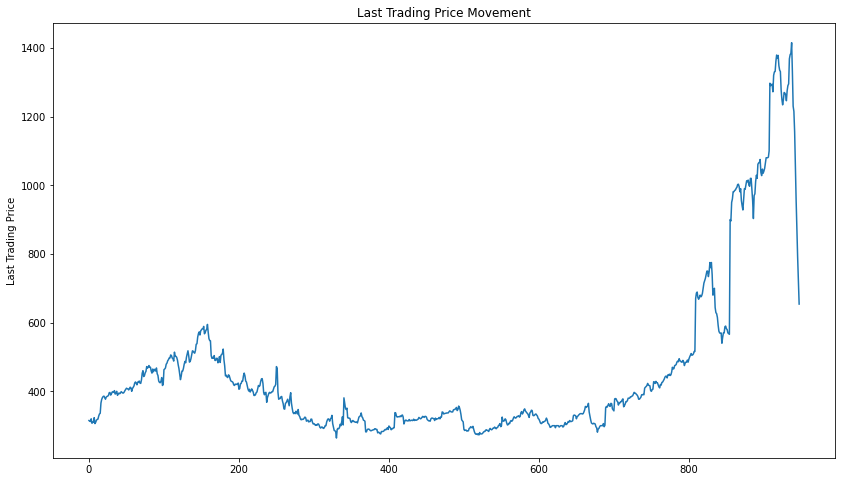

In [ ]:
df['Ltp'].plot(figsize=(14,8))
plt.ylabel("Last Trading Price")
plt.title("Last Trading Price Movement")
plt.show()

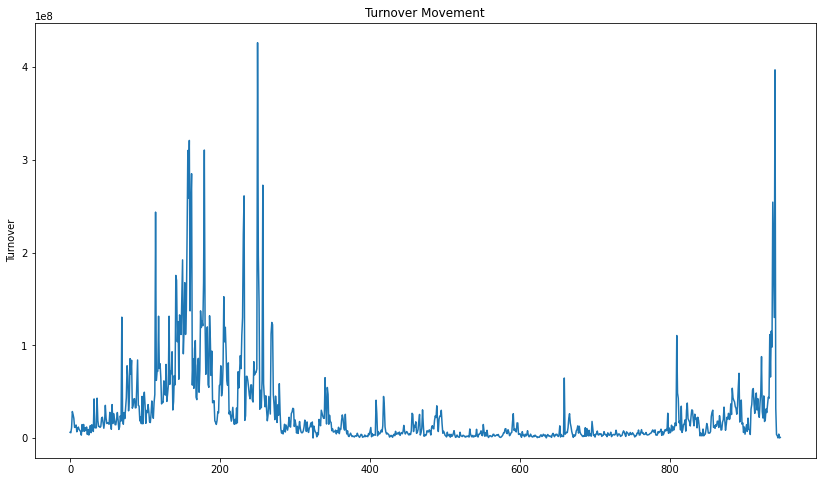

In [ ]:
turnover.plot(figsize=(14,8))
plt.ylabel("Turnover")
plt.title("Turnover Movement")
plt.show()

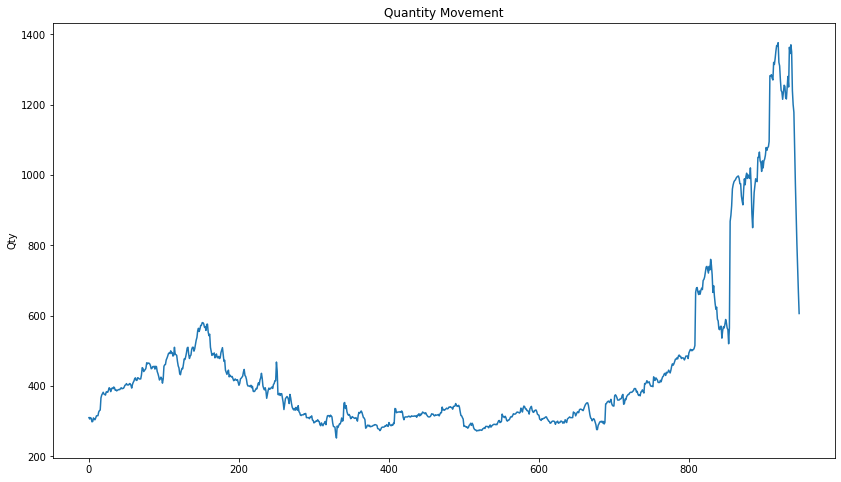

In [ ]:
qty.plot(figsize=(14,8))
plt.ylabel("Qty")
plt.title("Quantity Movement")
plt.show()

In [ ]:
df['economictext'].iloc[0]

"['EPF taking Oriental Cooperative Chairman Basnet owned Kohinoor Hill Housing to auction', 'Govt decides to develop Budhi Gandaki Hydro project in company model', 'Scarcity of chemical fertilizers due to negligence of contractor: Minister Yadav', 'Problems detected in transformers in Budhanilkantha', 'Gold price rises by Rs 100 per tola', 'Production of spring paddy up by 20 percent in Chitwan', 'Nepse increases by 41.39 points on Wednesday', 'DDC sells over 57,000 liters of yogurt on ‘Asar 15’', 'Appeal for formulation of laws relating to gold and silver business', 'Dollar hits all-time high', 'WB approves financing USD 275 million to Nepal to upgrade Butwal—Gorusinghe—Chanauta road', 'SC orders not to implement decision to reduce demarcation standards of Pokhara lakes']"

In [ ]:
df['politicaltext'].iloc[0]

"['Bamdev Gautam forms a new political party named ‘Nepal Communist Party Ekata Rastriya Abhiyan’', 'Unified Socialist Central Council meeting endorses 17-point proposal', 'Dahal is guilty in SPP: UML Chairman Oli', 'We have sown seeds of Maoism in UML, they will bear fruits after some time: Dahal', 'Accused of indecent behavior,&nbsp;Lumbini’s State Minister for Health Bimala Wali resigns', 'UML demands resignation of Gandaki CM', 'Replying to Dahal, UML’s Bhusal says, “The seeds of Maoism will grow no more.”', 'Govt cannot build Kerung-Kathmandu railway: Bishwa Prakash Sharma']"

In [ ]:
# Iterate over rows in economical news column

for index, row in df.iterrows(): 
    print (row["economictext"])

['EPF taking Oriental Cooperative Chairman Basnet owned Kohinoor Hill Housing to auction', 'Govt decides to develop Budhi Gandaki Hydro project in company model', 'Scarcity of chemical fertilizers due to negligence of contractor: Minister Yadav', 'Problems detected in transformers in Budhanilkantha', 'Gold price rises by Rs 100 per tola', 'Production of spring paddy up by 20 percent in Chitwan', 'Nepse increases by 41.39 points on Wednesday', 'DDC sells over 57,000 liters of yogurt on ‘Asar 15’', 'Appeal for formulation of laws relating to gold and silver business', 'Dollar hits all-time high', 'WB approves financing USD 275 million to Nepal to upgrade Butwal—Gorusinghe—Chanauta road', 'SC orders not to implement decision to reduce demarcation standards of Pokhara lakes']
['Stockbrokers permitted to operate their own TMS for online trading of shares', 'Newly-appointed Tourism Minister Shrestha calls for promoting tourism', 'Flights to Humla disrupted for three days', 'E. coli found in 

In [ ]:
# Iterate over rows in political news column

for index, row in df.iterrows(): 
    print (row["politicaltext"])

['Bamdev Gautam forms a new political party named ‘Nepal Communist Party Ekata Rastriya Abhiyan’', 'Unified Socialist Central Council meeting endorses 17-point proposal', 'Dahal is guilty in SPP: UML Chairman Oli', 'We have sown seeds of Maoism in UML, they will bear fruits after some time: Dahal', 'Accused of indecent behavior,&nbsp;Lumbini’s State Minister for Health Bimala Wali resigns', 'UML demands resignation of Gandaki CM', 'Replying to Dahal, UML’s Bhusal says, “The seeds of Maoism will grow no more.”', 'Govt cannot build Kerung-Kathmandu railway: Bishwa Prakash Sharma']
['Govt committed to development, good governance: Minister Karki', 'Central Council meeting of Unified Socialist being held', "Bamdev Gautam to launch 'CPN National Unity Campaign' Party today", 'Cabinet meeting called for 3 PM today', 'Speaker Agni Prasad Sapkota leaves for Azerbaijan', 'Seven vice-chairmen and 15 standing committee members in Bamdev Gautam-led party']
['Newly-appointed ministers to be sworn i

**Clean data in News Headling column**

In [ ]:
economic_clean_news = []

for i in range(0, len(df["economictext"])): 
    economic_clean_news.append(re.sub("\n", ' ', df["economictext"][i]))  # replace n\ with ' '
    economic_clean_news[i] = re.sub(r'[^a-zA-z0-9\s]','',economic_clean_news[i]) # removes all than alphabets and numbers

In [ ]:
# Show first row in economical news column

economic_clean_news[0]

'[EPF taking Oriental Cooperative Chairman Basnet owned Kohinoor Hill Housing to auction Govt decides to develop Budhi Gandaki Hydro project in company model Scarcity of chemical fertilizers due to negligence of contractor Minister Yadav Problems detected in transformers in Budhanilkantha Gold price rises by Rs 100 per tola Production of spring paddy up by 20 percent in Chitwan Nepse increases by 4139 points on Wednesday DDC sells over 57000 liters of yogurt on Asar 15 Appeal for formulation of laws relating to gold and silver business Dollar hits alltime high WB approves financing USD 275 million to Nepal to upgrade ButwalGorusingheChanauta road SC orders not to implement decision to reduce demarcation standards of Pokhara lakes]'

In [ ]:
political_clean_news = []

for i in range(0, len(df["politicaltext"])): 
    political_clean_news.append(re.sub("\n", ' ', df["politicaltext"][i]))  # replace n\ with ' '
    political_clean_news[i] = re.sub(r'[^a-zA-z0-9\s]','',political_clean_news[i]) # removes all than alphabets and numbers

In [ ]:
# Show first row in political news column

political_clean_news[0]

'[Bamdev Gautam forms a new political party named Nepal Communist Party Ekata Rastriya Abhiyan Unified Socialist Central Council meeting endorses 17point proposal Dahal is guilty in SPP UML Chairman Oli We have sown seeds of Maoism in UML they will bear fruits after some time Dahal Accused of indecent behaviornbspLumbinis State Minister for Health Bimala Wali resigns UML demands resignation of Gandaki CM Replying to Dahal UMLs Bhusal says The seeds of Maoism will grow no more Govt cannot build KerungKathmandu railway Bishwa Prakash Sharma]'

In [ ]:
df['economictext'] = economic_clean_news
df['politicaltext'] = political_clean_news

In [ ]:
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext,economicaltext
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,[EPF taking Oriental Cooperative Chairman Basn...,[Bamdev Gautam forms a new political party nam...,[EPF taking Oriental Cooperative Chairman Basn...
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,[Stockbrokers permitted to operate their own T...,[Govt committed to development good governance...,[Stockbrokers permitted to operate their own T...
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,[Nepal received FDI commitments of Rs 5156 bil...,[Newlyappointed ministers to be sworn in today...,[Nepal received FDI commitments of Rs 5156 bil...
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,[17 cooperatives put in blacklist on charge of...,[National Assembly meeting being held today CP...,[17 cooperatives put in blacklist on charge of...
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,[Agreement signed to study the feasibility of ...,[National Assembly meeting at 1 PM today with ...,[Agreement signed to study the feasibility of ...
...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,[NEPSE records trade of shares worth 6 billion...,[NC summons CWC meeting for Tuesday Parties on...,[NEPSE records trade of shares worth 6 billion...
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,[Govt laxity blamed for growing market ills Ne...,[House yet to endorse remaining bills of budge...,[Govt laxity blamed for growing market ills Ne...
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,[Capital threshold for industries to be raised...,[Land developers school responsible for wall c...,[Capital threshold for industries to be raised...
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,[Flawed recommendation process of justices dra...,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...


**Sentiment Analysis** <br>
TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [ ]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
# Create subjectivity and polarity in new column of economictext
df['economic-subjectivity'] = df['economictext'].apply(getSubjectivity)
df['economic-polarity'] = df['economictext'].apply(getPolarity)

In [ ]:
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext,economicaltext,economic-subjectivity,economic-polarity
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,[EPF taking Oriental Cooperative Chairman Basn...,[Bamdev Gautam forms a new political party nam...,[EPF taking Oriental Cooperative Chairman Basn...,0.457500,0.017500
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,[Stockbrokers permitted to operate their own T...,[Govt committed to development good governance...,[Stockbrokers permitted to operate their own T...,0.195556,0.017778
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,[Nepal received FDI commitments of Rs 5156 bil...,[Newlyappointed ministers to be sworn in today...,[Nepal received FDI commitments of Rs 5156 bil...,0.225000,-0.012500
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,[17 cooperatives put in blacklist on charge of...,[National Assembly meeting being held today CP...,[17 cooperatives put in blacklist on charge of...,0.253704,0.038889
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,[Agreement signed to study the feasibility of ...,[National Assembly meeting at 1 PM today with ...,[Agreement signed to study the feasibility of ...,0.280303,0.042424
...,...,...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,[NEPSE records trade of shares worth 6 billion...,[NC summons CWC meeting for Tuesday Parties on...,[NEPSE records trade of shares worth 6 billion...,0.277273,0.218182
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,[Govt laxity blamed for growing market ills Ne...,[House yet to endorse remaining bills of budge...,[Govt laxity blamed for growing market ills Ne...,0.303030,0.090909
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,[Capital threshold for industries to be raised...,[Land developers school responsible for wall c...,[Capital threshold for industries to be raised...,0.293182,0.337121
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,[Flawed recommendation process of justices dra...,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,0.315774,0.166369


In [ ]:
# Create subjectivity and polarity in new column of politicaltext
df['political-subjectivity'] = df['politicaltext'].apply(getSubjectivity)
df['political-polarity'] = df['politicaltext'].apply(getPolarity)

In [ ]:
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext,economicaltext,economic-subjectivity,economic-polarity,political-subjectivity,political-polarity
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,[EPF taking Oriental Cooperative Chairman Basn...,[Bamdev Gautam forms a new political party nam...,[EPF taking Oriental Cooperative Chairman Basn...,0.457500,0.017500,0.460909,-0.122727
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,[Stockbrokers permitted to operate their own T...,[Govt committed to development good governance...,[Stockbrokers permitted to operate their own T...,0.195556,0.017778,0.425000,0.350000
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,[Nepal received FDI commitments of Rs 5156 bil...,[Newlyappointed ministers to be sworn in today...,[Nepal received FDI commitments of Rs 5156 bil...,0.225000,-0.012500,0.457792,0.169481
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,[17 cooperatives put in blacklist on charge of...,[National Assembly meeting being held today CP...,[17 cooperatives put in blacklist on charge of...,0.253704,0.038889,0.570909,0.241818
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,[Agreement signed to study the feasibility of ...,[National Assembly meeting at 1 PM today with ...,[Agreement signed to study the feasibility of ...,0.280303,0.042424,0.300000,0.128788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,[NEPSE records trade of shares worth 6 billion...,[NC summons CWC meeting for Tuesday Parties on...,[NEPSE records trade of shares worth 6 billion...,0.277273,0.218182,0.461818,0.004545
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,[Govt laxity blamed for growing market ills Ne...,[House yet to endorse remaining bills of budge...,[Govt laxity blamed for growing market ills Ne...,0.303030,0.090909,0.326515,-0.087879
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,[Capital threshold for industries to be raised...,[Land developers school responsible for wall c...,[Capital threshold for industries to be raised...,0.293182,0.337121,0.444805,-0.012987
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,[Flawed recommendation process of justices dra...,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,0.315774,0.166369,0.343232,-0.007475


**Summary Statistics and Visualize of Economic Text**

In [ ]:
#Statistics of Economic Text Subjectivity
df['economic-subjectivity'].describe()

count    948.000000
mean       0.320811
std        0.176394
min        0.000000
25%        0.200000
50%        0.315757
75%        0.439015
max        1.000000
Name: economic-subjectivity, dtype: float64

In [ ]:
df['economic-subjectivity'].value_counts()

0.000000    62
0.300000    16
0.100000    14
0.500000    14
0.400000    12
            ..
0.298829     1
0.256250     1
0.257860     1
0.252576     1
0.563333     1
Name: economic-subjectivity, Length: 607, dtype: int64

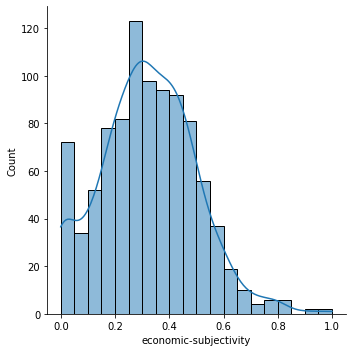

In [ ]:
sns.displot(df['economic-subjectivity'], bins=20, kde=True);

In [ ]:
#Statistics of Economic Text Polarity
df['economic-polarity'].describe()

count    948.000000
mean       0.059365
std        0.141399
min       -0.600000
25%       -0.006184
50%        0.050000
75%        0.136552
max        1.000000
Name: economic-polarity, dtype: float64

In [ ]:
#Statistics of Economic Text Polarity
df['economic-polarity'].value_counts()

 0.000000    104
 0.100000     18
 0.250000     17
 0.050000     16
 0.068182     10
            ... 
-0.015000      1
-0.150000      1
 0.304167      1
 0.006667      1
 0.166369      1
Name: economic-polarity, Length: 578, dtype: int64

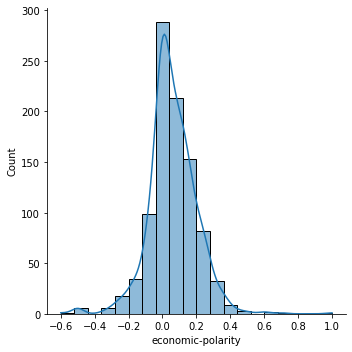

In [ ]:
sns.displot(df['economic-polarity'], bins=20, kde=True);

In [ ]:
#Statistics of Political Text Subjectivity
df['political-subjectivity'].describe()

count    948.000000
mean       0.307988
std        0.198543
min        0.000000
25%        0.175000
50%        0.300000
75%        0.428417
max        1.000000
Name: political-subjectivity, dtype: float64

In [ ]:
df['political-subjectivity'].value_counts()

0.000000    90
0.500000    40
0.100000    23
0.250000    18
0.454545    14
            ..
0.177778     1
0.120000     1
0.412037     1
0.344353     1
0.277381     1
Name: political-subjectivity, Length: 528, dtype: int64

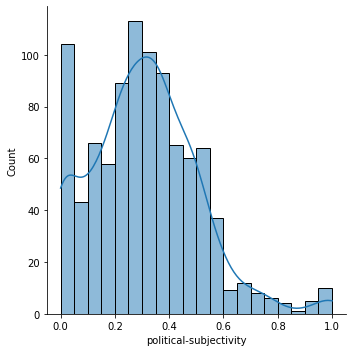

In [ ]:
sns.displot(df['political-subjectivity'], bins=20, kde=True);

In [ ]:
#Statistics of Political Text Polarity
df['political-polarity'].describe()

count    948.000000
mean       0.044399
std        0.137091
min       -0.650000
25%       -0.004505
50%        0.027435
75%        0.110278
max        0.600000
Name: political-polarity, dtype: float64

In [ ]:
df['political-polarity'].value_counts()

 0.000000    158
 0.100000     15
 0.136364     13
 0.050000     10
 0.068182      9
            ... 
-0.044444      1
 0.316667      1
 0.070707      1
 0.159642      1
-0.007475      1
Name: political-polarity, Length: 545, dtype: int64

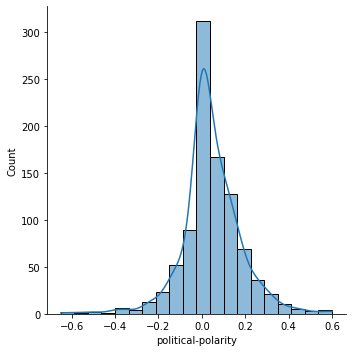

In [ ]:
sns.displot(df['political-polarity'], bins=20, kde=True);

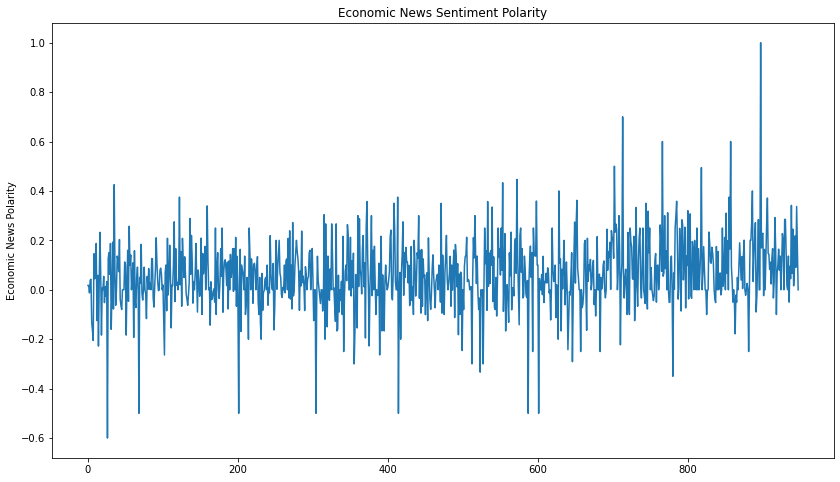

In [ ]:
df['economic-polarity'].plot(figsize=(14,8))
plt.ylabel("Economic News Polarity")
plt.title("Economic News Sentiment Polarity")
plt.show()

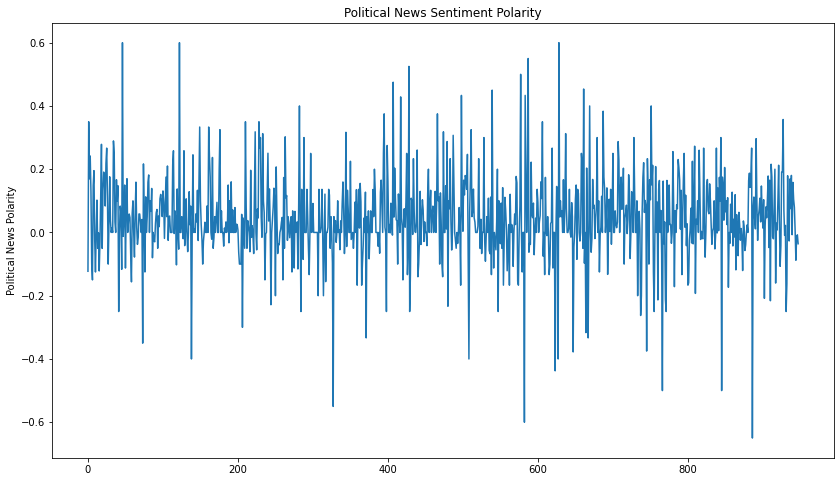

In [ ]:
df['political-polarity'].plot(figsize=(14,8))
plt.ylabel("Political News Polarity")
plt.title("Political News Sentiment Polarity")
plt.show()

In [ ]:
# "1" when  Ltp value rose or stayed as the same;
# "0" when Ltp value decreased.

df['Ltp Next Value'] = df['Ltp'].shift(-1)

In [ ]:
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext,economicaltext,economic-subjectivity,economic-polarity,political-subjectivity,political-polarity,Ltp Next Value
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,[EPF taking Oriental Cooperative Chairman Basn...,[Bamdev Gautam forms a new political party nam...,[EPF taking Oriental Cooperative Chairman Basn...,0.457500,0.017500,0.460909,-0.122727,313.0
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,[Stockbrokers permitted to operate their own T...,[Govt committed to development good governance...,[Stockbrokers permitted to operate their own T...,0.195556,0.017778,0.425000,0.350000,312.0
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,[Nepal received FDI commitments of Rs 5156 bil...,[Newlyappointed ministers to be sworn in today...,[Nepal received FDI commitments of Rs 5156 bil...,0.225000,-0.012500,0.457792,0.169481,320.0
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,[17 cooperatives put in blacklist on charge of...,[National Assembly meeting being held today CP...,[17 cooperatives put in blacklist on charge of...,0.253704,0.038889,0.570909,0.241818,307.0
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,[Agreement signed to study the feasibility of ...,[National Assembly meeting at 1 PM today with ...,[Agreement signed to study the feasibility of ...,0.280303,0.042424,0.300000,0.128788,310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,[NEPSE records trade of shares worth 6 billion...,[NC summons CWC meeting for Tuesday Parties on...,[NEPSE records trade of shares worth 6 billion...,0.277273,0.218182,0.461818,0.004545,869.0
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,[Govt laxity blamed for growing market ills Ne...,[House yet to endorse remaining bills of budge...,[Govt laxity blamed for growing market ills Ne...,0.303030,0.090909,0.326515,-0.087879,790.0
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,[Capital threshold for industries to be raised...,[Land developers school responsible for wall c...,[Capital threshold for industries to be raised...,0.293182,0.337121,0.444805,-0.012987,719.0
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,[Flawed recommendation process of justices dra...,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,0.315774,0.166369,0.343232,-0.007475,654.0


In [ ]:
df['Label'] = df.apply(lambda x: 1 if (x['Ltp Next Value']>= x['Ltp']) else 0, axis =1)

df[['Ltp', 'Ltp Next Value', 'Label']].head(5)

,Ltp,Ltp Next Value,Label
0,315.0,313.0,0
1,313.0,312.0,0
2,312.0,320.0,1
3,320.0,307.0,0
4,307.0,310.0,1


In [ ]:
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext,economicaltext,economic-subjectivity,economic-polarity,political-subjectivity,political-polarity,Ltp Next Value,Label
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,[EPF taking Oriental Cooperative Chairman Basn...,[Bamdev Gautam forms a new political party nam...,[EPF taking Oriental Cooperative Chairman Basn...,0.457500,0.017500,0.460909,-0.122727,313.0,0
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,[Stockbrokers permitted to operate their own T...,[Govt committed to development good governance...,[Stockbrokers permitted to operate their own T...,0.195556,0.017778,0.425000,0.350000,312.0,0
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,[Nepal received FDI commitments of Rs 5156 bil...,[Newlyappointed ministers to be sworn in today...,[Nepal received FDI commitments of Rs 5156 bil...,0.225000,-0.012500,0.457792,0.169481,320.0,1
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,[17 cooperatives put in blacklist on charge of...,[National Assembly meeting being held today CP...,[17 cooperatives put in blacklist on charge of...,0.253704,0.038889,0.570909,0.241818,307.0,0
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,[Agreement signed to study the feasibility of ...,[National Assembly meeting at 1 PM today with ...,[Agreement signed to study the feasibility of ...,0.280303,0.042424,0.300000,0.128788,310.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,[NEPSE records trade of shares worth 6 billion...,[NC summons CWC meeting for Tuesday Parties on...,[NEPSE records trade of shares worth 6 billion...,0.277273,0.218182,0.461818,0.004545,869.0,0
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,[Govt laxity blamed for growing market ills Ne...,[House yet to endorse remaining bills of budge...,[Govt laxity blamed for growing market ills Ne...,0.303030,0.090909,0.326515,-0.087879,790.0,0
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,[Capital threshold for industries to be raised...,[Land developers school responsible for wall c...,[Capital threshold for industries to be raised...,0.293182,0.337121,0.444805,-0.012987,719.0,0
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,[Flawed recommendation process of justices dra...,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,0.315774,0.166369,0.343232,-0.007475,654.0,0


In [ ]:
# Show Ltp Next Value and Label with Date

df_label = df[['Ltp Next Value', 'Label']]
df_label

,Ltp Next Value,Label
0,313.0,0
1,312.0,0
2,320.0,1
3,307.0,0
4,310.0,1
...,...,...
943,869.0,0
944,790.0,0
945,719.0,0
946,654.0,0


In [ ]:
# Drop NaN row

df_label = df_label.dropna()
df_label

,Ltp Next Value,Label
0,313.0,0
1,312.0,0
2,320.0,1
3,307.0,0
4,310.0,1
...,...,...
942,955.0,0
943,869.0,0
944,790.0,0
945,719.0,0


In [ ]:
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economictext,politicaltext,economicaltext,economic-subjectivity,economic-polarity,political-subjectivity,political-polarity,Ltp Next Value,Label
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,[EPF taking Oriental Cooperative Chairman Basn...,[Bamdev Gautam forms a new political party nam...,[EPF taking Oriental Cooperative Chairman Basn...,0.457500,0.017500,0.460909,-0.122727,313.0,0
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,[Stockbrokers permitted to operate their own T...,[Govt committed to development good governance...,[Stockbrokers permitted to operate their own T...,0.195556,0.017778,0.425000,0.350000,312.0,0
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,[Nepal received FDI commitments of Rs 5156 bil...,[Newlyappointed ministers to be sworn in today...,[Nepal received FDI commitments of Rs 5156 bil...,0.225000,-0.012500,0.457792,0.169481,320.0,1
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,[17 cooperatives put in blacklist on charge of...,[National Assembly meeting being held today CP...,[17 cooperatives put in blacklist on charge of...,0.253704,0.038889,0.570909,0.241818,307.0,0
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,[Agreement signed to study the feasibility of ...,[National Assembly meeting at 1 PM today with ...,[Agreement signed to study the feasibility of ...,0.280303,0.042424,0.300000,0.128788,310.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,[NEPSE records trade of shares worth 6 billion...,[NC summons CWC meeting for Tuesday Parties on...,[NEPSE records trade of shares worth 6 billion...,0.277273,0.218182,0.461818,0.004545,869.0,0
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,[Govt laxity blamed for growing market ills Ne...,[House yet to endorse remaining bills of budge...,[Govt laxity blamed for growing market ills Ne...,0.303030,0.090909,0.326515,-0.087879,790.0,0
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,[Capital threshold for industries to be raised...,[Land developers school responsible for wall c...,[Capital threshold for industries to be raised...,0.293182,0.337121,0.444805,-0.012987,719.0,0
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,[Flawed recommendation process of justices dra...,[Bajaj V15 hits Nepali roads PokharaDelhi bus ...,0.315774,0.166369,0.343232,-0.007475,654.0,0


In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Ltp', 'Qty', 'Turnover', 'economictext',
       'politicaltext', 'economicaltext', 'economic-subjectivity',
       'economic-polarity', 'political-subjectivity', 'political-polarity',
       'Ltp Next Value', 'Label'],
      dtype='object')

In [ ]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Date', 'Open', 'High', 'Low', 'Ltp', 'Qty', 'Turnover','economic-subjectivity',
                'economic-polarity', 'political-subjectivity', 'political-polarity', 'Label']
df =  df[keep_columns]
df

,Date,Open,High,Low,Ltp,Qty,Turnover,economic-subjectivity,economic-polarity,political-subjectivity,political-polarity,Label
0,2022-06-29,318.90,318.90,310.00,315.0,310.00,6127716.20,0.457500,0.017500,0.460909,-0.122727,0
1,2022-06-28,312.00,316.50,306.00,313.0,306.00,5707986.70,0.195556,0.017778,0.425000,0.350000,0
2,2022-06-27,322.00,325.00,310.00,312.0,310.00,11125995.50,0.225000,-0.012500,0.457792,0.169481,1
3,2022-06-26,312.90,320.00,308.00,320.0,308.00,28577745.10,0.253704,0.038889,0.570909,0.241818,0
4,2022-06-24,305.00,310.00,298.20,307.0,298.20,25399389.80,0.280303,0.042424,0.300000,0.128788,1
...,...,...,...,...,...,...,...,...,...,...,...,...
943,2016-07-17,869.00,955.00,886.00,955.0,886.00,2538590.00,0.277273,0.218182,0.461818,0.004545,0
944,2016-07-14,790.00,869.00,805.00,869.0,805.00,151344.00,0.303030,0.090909,0.326515,-0.087879,0
945,2016-07-13,719.00,790.00,733.00,790.0,733.00,4231540.00,0.293182,0.337121,0.444805,-0.012987,0
946,2016-07-12,654.00,719.00,667.00,719.0,667.00,89570.00,0.315774,0.166369,0.343232,-0.007475,0


In [ ]:
df.to_csv("updated-dataset-with-subjectivity-polarity-label.csv")

In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df.shape

(948, 11)

**Modelling** <br>
Split the data in feature matrix (X) and target vector (y).

In [ ]:
# Create feature data set
X = df
X = np.array(X.drop(['Label'], 1))

# Create target data set
y = np.array(df['Label'])

We split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [ ]:
# Split data into 80% training and 20% testing data sets

split = int(0.8*len(df))

In [ ]:
X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(758, 10)
(758,)
(190, 10)
(190,)


In [ ]:
# Create and train the model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [ ]:
# Show model's predictions
predictions = model.predict(X_test)
predictions

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Show actual values
y_test

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Show model metrics 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.94      0.79        77
           1       0.94      0.71      0.81       113

    accuracy                           0.80       190
   macro avg       0.81      0.82      0.80       190
weighted avg       0.84      0.80      0.80       190



**Feature scaling** <br>
We will standardise the data using scikit-learn's preprocessing.scale() algorithm so that it is all on one scale.

In [ ]:
# # Standardise X's
# X_train = scale(X_train)
# X_test = scale(X_test)

In [ ]:
models = {"LDA":LinearDiscriminantAnalysis(),
          "SVMClassifier": SVC(),
          'SGDClassifier': SGDClassifier(),
          "KNN":KNeighborsClassifier(),
          "Random Forest":RandomForestClassifier(),
        }

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test): 
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data(with no labels)
    X_test: testing data(with no labels)
    y_train: training labels
    y_test: testing labels
    """
    
    #set random seed
    np.random.seed(42)

    # Making a dictionary to keep model scoresS
    model_scores = {}

    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)

        #Evaluate the model and  append  it's score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [ ]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

In [ ]:
model_scores

{'LDA': 0.8,
 'SVMClassifier': 0.6052631578947368,
 'SGDClassifier': 0.5947368421052631,
 'KNN': 0.5842105263157895,
 'Random Forest': 0.5368421052631579}

**Model Comparison**

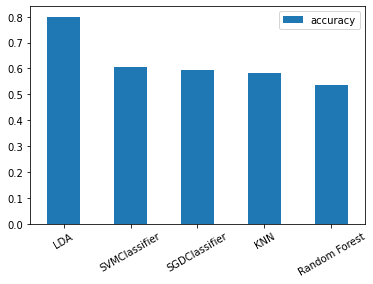

In [ ]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()

plt.xticks(rotation=30, horizontalalignment='center');

**Hyperparamter Tuning**

In [ ]:
#Hyperparameters
cv_lda=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'n_components':[1,2,3,4,5]   
}

grid_svm = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear', 'poly', 'sigmoid', 'precomputed']
    }

grid_sgd = {
    'penalty': ['l2','l1','elasticnet'],
    'n_jobs': [-1],
    'max_iter': [20,50,100,500,1000],
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error',
            'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'validation_fraction': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

grid_knn ={
    'leaf_size':np.arange(1,50),
    'n_neighbors':np.arange(1,30),
    'p':[1,2]
}



grid_rf = {
    'n_estimators': [20, 50, 100, 500, 1000],  
    'max_depth': np.arange(1, 100, 1),  
    'min_samples_split': [2, 10, 9], 
    'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
    'bootstrap': [True, False], 
    'random_state': [1, 2, 30, 42]
}

In [ ]:
# Tune LinearDiscriminantAnalysis for cv=5

np.random.seed(42)

# Setup random hyperparameter search for LinearDiscriminantAnalysis
lda_cv5 = RandomizedSearchCV(LinearDiscriminantAnalysis(),
                                param_distributions=grid_lda,
                                cv=5,
                                n_iter=10,
                                verbose=True)

#Fit random hyperparameter search model for LinearDiscriminantAnalysis 
lda_cv5.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
                   param_distributions={'n_components': [1, 2, 3, 4, 5],
                                        'solver': ['svd', 'lsqr', 'eigen']},
                   verbose=True)

In [ ]:
# Find the best parameters
lda_cv5.best_params_

{'solver': 'lsqr', 'n_components': 1}

In [ ]:
model_lda_cv5=LinearDiscriminantAnalysis(solver = 'lsqr', n_components= 1).fit(X_train,y_train)

In [ ]:
# Show lda model's predictions for cv=5
predictions_lda_cv5 = model_lda_cv5.predict(X_test)
predictions_lda_cv5

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Show lda model metrics for cv=5
print(classification_report(y_test, predictions_lda_cv5))

              precision    recall  f1-score   support

           0       0.68      0.92      0.78        77
           1       0.93      0.71      0.80       113

    accuracy                           0.79       190
   macro avg       0.81      0.82      0.79       190
weighted avg       0.83      0.79      0.80       190



In [ ]:
# Tune LinearDiscriminantAnalysis for cv=10

np.random.seed(42)

# Setup random hyperparameter search for LinearDiscriminantAnalysis
lda_cv10 = RandomizedSearchCV(LinearDiscriminantAnalysis(),
                                param_distributions=grid_lda,
                                cv=10,
                                n_iter=10,
                                verbose=True)

#Fit random hyperparameter search model for LinearDiscriminantAnalysis 
lda_cv10.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=LinearDiscriminantAnalysis(),
                   param_distributions={'n_components': [1, 2, 3, 4, 5],
                                        'solver': ['svd', 'lsqr', 'eigen']},
                   verbose=True)

In [ ]:
# Find the best parameters
lda_cv10.best_params_

{'solver': 'svd', 'n_components': 1}

In [ ]:
# Evaluate the randomized search LinearDiscriminantAnalysis Model
lda_cv10.score(X_test, y_test)

0.8

In [ ]:
model_lda_cv10=LinearDiscriminantAnalysis(solver = 'svd', n_components= 1).fit(X_train,y_train)

# Show lda model's predictions for cv=5
predictions_lda_cv10 = model_lda_cv10.predict(X_test)

# Show lda model metrics for cv=5
print(classification_report(y_test, predictions_lda_cv10))

              precision    recall  f1-score   support

           0       0.69      0.94      0.79        77
           1       0.94      0.71      0.81       113

    accuracy                           0.80       190
   macro avg       0.81      0.82      0.80       190
weighted avg       0.84      0.80      0.80       190



In [ ]:
# #Confusion Matrix
# print(confusion_matrix(y_test, predict_lda))

# sns.set(font_scale=1.5)

# def plot_conf_mat(y_test, y_predicts):
#   """
#   Plot a confusion matrix using Seaborn's heatmap()
#   """
#   fig, ax = plt.subplots(figsize=(3,3))
#   ax = sns.heatmap(confusion_matrix(y_test,predict_lda),
#                   annot=True,
#                    cbar=False)
#   plt.xlabel("True label")
#   plt.ylabel("Predicted label")

# plot_conf_mat(y_test, predict_lda)

In [ ]:
# Tune SVM 

np.random.seed(42)

# Setup random hyperparameter search for SVM
svm = RandomizedSearchCV(SVC(),
                        param_distributions=grid_svm,
                        cv=10,
                        n_iter=20,
                        verbose=True)

#Fit random hyperparameter search model for SVM 
svm.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
# Find the best parameters
svm.best_params_

In [ ]:
# Evaluate the randomized search SVM Model
svm.score(X_test, y_test)

0.7736842105263158

In [ ]:
# Tune SGDClassifier 

np.random.seed(42)

# Setup random hyperparameter search for SGDClassifier
sgd = RandomizedSearchCV(SGDClassifier(),
                        param_distributions=grid_sgd,
                        cv=10,
                        n_iter=20,
                        verbose=2)

#Fit random hyperparameter search model for SGDClassifier 
sgd.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fraction=0.2; total time=   0.0s
[CV] END loss=log, max_iter=20, n_jobs=-1, penalty=elasticnet, validation_fractio

RandomizedSearchCV(cv=10, estimator=SGDClassifier(), n_iter=20,
                   param_distributions={'loss': ['hinge', 'log_loss', 'log',
                                                 'modified_huber',
                                                 'squared_hinge', 'perceptron',
                                                 'squared_error', 'huber',
                                                 'epsilon_insensitive',
                                                 'squared_epsilon_insensitive'],
                                        'max_iter': [20, 50, 100, 500, 1000],
                                        'n_jobs': [-1],
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'validation_fraction': [0.1, 0.2, 0.3,
                                                                0.4, 0.5, 0.6,
                                                                0.7, 0.8,
                                       

In [ ]:
# Find the best parameters
sgd.best_params_

{'validation_fraction': 0.8,
 'penalty': 'l1',
 'n_jobs': -1,
 'max_iter': 50,
 'loss': 'hinge'}

In [ ]:
# Evaluate the randomized search SGDClassifier Model
sgd.score(X_test, y_test)

0.7684210526315789

In [ ]:
# Tune KNeighborsClassifier 

np.random.seed(42)

# Setup random hyperparameter search for KNeighborsClassifier
knn = RandomizedSearchCV(KNeighborsClassifier(),
                        param_distributions=grid_knn,
                        cv=10,
                        n_iter=20,
                        verbose=True)

#Fit random hyperparameter search model for KNeighborsClassifier 
knn.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'p': [1, 2]},
                   verbose=True)

In [ ]:
# Find the best parameters
knn.best_params_

{'p': 1, 'n_neighbors': 25, 'leaf_size': 15}

In [ ]:
# Evaluate the randomized search KNeighborsClassifier Model
knn.score(X_test, y_test)

0.631578947368421

In [ ]:
# Tune RandomForestClassifier 

np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=grid_rf,
                        cv=10,
                        n_iter=200,
                        verbose=2,
                        n_jobs=-1)

#Fit random hyperparameter search model for RandomForestClassifier 
rf.fit(X_train,y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13]),
                                        'min_samples_split': [2, 10, 9],
                                        'n_estimators': [20, 50, 100, 500,
                                                         1000],
                          

In [ ]:
# Find the best parameters
rf.best_params_ 

{'random_state': 2,
 'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 98,
 'bootstrap': True}

In [ ]:
# Evaluate the randomized search KNeighborsClassifier Model
rf.score(X_test, y_test)

0.6052631578947368

In [ ]:
model_scores

{'LDA': 0.7421052631578947,
 'SVMClassifier': 0.6,
 'SGDClassifier': 0.7157894736842105,
 'KNN': 0.5526315789473685,
 'Random Forest': 0.6368421052631579}

In [ ]:
model_rf = RandomForestClassifier(random_state= 2,n_estimators= 1000,min_samples_split= 2,min_samples_leaf= 1,max_depth= 98,bootstrap= True)
model_rf.fit(X_train, y_train)
predict_rf = model_rf.predict(X_test)

In [ ]:
# Final Classification Report
print(classification_report(model_rf.predict(X_test),y_test)) 

              precision    recall  f1-score   support

           0       0.31      0.52      0.39        46
           1       0.81      0.63      0.71       144

    accuracy                           0.61       190
   macro avg       0.56      0.58      0.55       190
weighted avg       0.69      0.61      0.63       190



**Create a function for confusion matrix**

In [ ]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax


-------------- LinearDiscriminantAnalysis ---------------



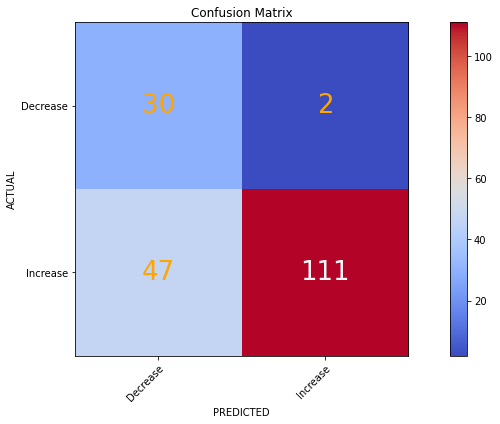

              precision    recall  f1-score   support

    Decrease       0.39      0.94      0.55        32
    Increase       0.98      0.70      0.82       158

    accuracy                           0.74       190
   macro avg       0.69      0.82      0.68       190
weighted avg       0.88      0.74      0.77       190


-------------- SVM Classification ---------------



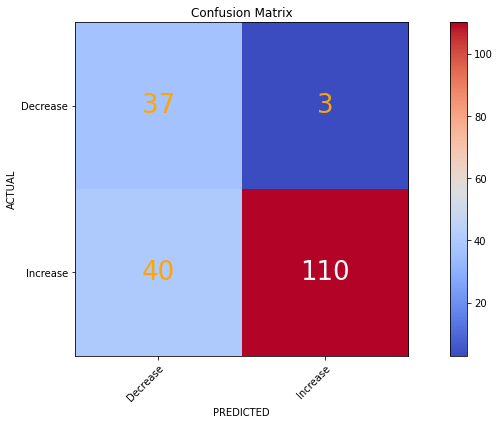

              precision    recall  f1-score   support

    Decrease       0.48      0.93      0.63        40
    Increase       0.97      0.73      0.84       150

    accuracy                           0.77       190
   macro avg       0.73      0.83      0.73       190
weighted avg       0.87      0.77      0.79       190


-------------- SGDClassifier ---------------



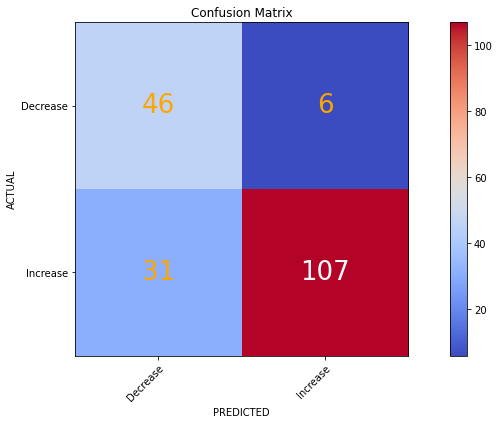

              precision    recall  f1-score   support

    Decrease       0.60      0.88      0.71        52
    Increase       0.95      0.78      0.85       138

    accuracy                           0.81       190
   macro avg       0.77      0.83      0.78       190
weighted avg       0.85      0.81      0.81       190


-------------- KNeighborsClassifier ---------------



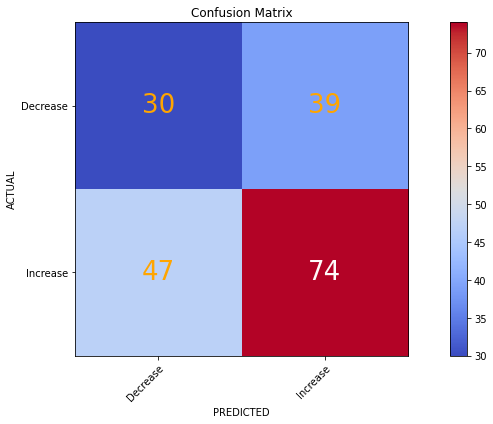

              precision    recall  f1-score   support

    Decrease       0.39      0.43      0.41        69
    Increase       0.65      0.61      0.63       121

    accuracy                           0.55       190
   macro avg       0.52      0.52      0.52       190
weighted avg       0.56      0.55      0.55       190


-------------- RandomForestClassifier ---------------



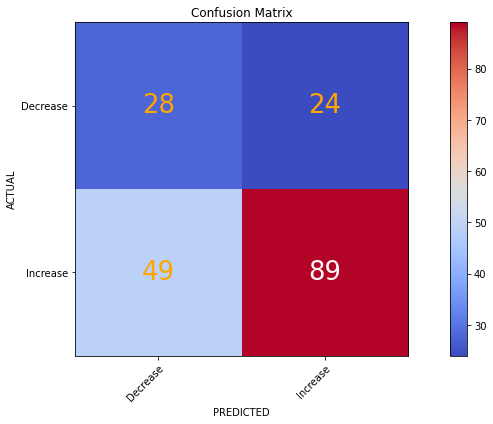

              precision    recall  f1-score   support

    Decrease       0.36      0.54      0.43        52
    Increase       0.79      0.64      0.71       138

    accuracy                           0.62       190
   macro avg       0.58      0.59      0.57       190
weighted avg       0.67      0.62      0.63       190



In [ ]:
# test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(solver='svd', n_components= 1),
            'SVM Classification': SVC(kernel='linear', gamma= 0.01, C= 10),
            'SGDClassifier': SGDClassifier(validation_fraction= 0.8, penalty= 'l1',n_jobs= -1,max_iter= 50, loss= 'hinge'),
            'KNeighborsClassifier':KNeighborsClassifier(p= 2, n_neighbors= 7, leaf_size= 42),
            # 'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(random_state= 30, n_estimators= 50, min_samples_split= 2, min_samples_leaf= 3, max_depth= 98, bootstrap= False)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))